## Classical Diffusion Model on QG Dataset ##

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [125]:
import matplotlib.pyplot as plt

def plot_grid(images, labels):
    fig, axs = plt.subplots(images.shape[0], images.shape[1], figsize=(10,10))
    for i in range(images.shape[0]):
        for j in range(images.shape[1]):
            axs[i, j].imshow(images[i, :, (j*3):((j+1)*3)])
            try:
                axs[i, j].set_title(labels[i][j])
            except:
                pass
            axs[i, j].axis('off')

# def plot_grid(images, labels):
#     n_images = images.shape[0]
#     n_steps = images.shape[1] // images.shape[2] 
#     fig, axs = plt.subplots(n_images, n_steps, figsize=(3 * n_steps, 3 * n_images))

#     for i in range(n_images):
#         for j in range(n_steps):
#             axs[i, j].imshow(images[i, :, (j*3):((j+1)*3)].cpu().numpy())
#             if i == 0:  # Set title for the top row
#                 axs[i, j].set_title(labels[0][j])
#             axs[i, j].axis('off')

#     plt.show()

def show_images(data, samples=10):
    fig, axes = plt.subplots(1, samples, figsize=(20, 2))
    indices = np.random.randint(0, len(data), samples)
    for i, idx in enumerate(indices):
        image, label = data[idx]
        image = image.squeeze().numpy()
        # axes[i].imshow(image, cmap='gray')
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        # print(image.squeeze().shape)
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
BATCH_SIZE = 256

In [147]:
# https://discuss.pytorch.org/t/loading-hdf5-data-for-training-a-network-in-pytorch-is-super-slow/158433
import h5py

class TorchGenerator(): # type: ignore
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        samplex = torch.tensor(self.x[idx], dtype=torch.float)
        sampley = torch.tensor(self.y[idx], dtype = torch.int)

        return samplex, sampley

# data_f = h5py.File("../../data/QG_train_normalized_N3_M2_bilinear_xl")
data_f = h5py.File("../../data/QG_train_normalized_16_xl")
x_train = data_f['X']
y_train = data_f['y']

training_data = TorchGenerator(x_train, y_train)
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE)

for data, label in train_dataloader:
    print(data, label)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

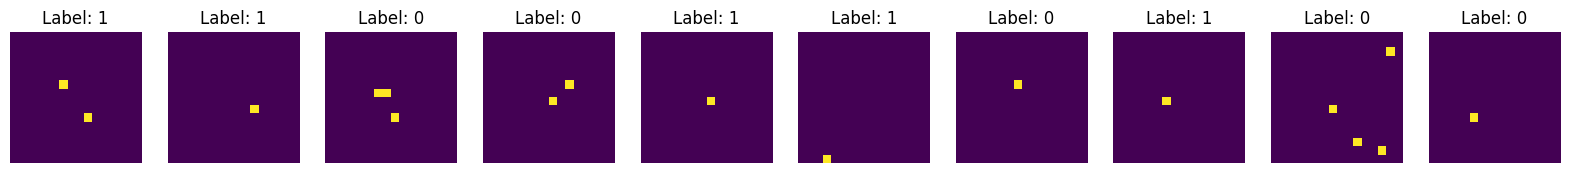

In [148]:
show_images(training_data)

In [65]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion(x_0, t, device=device):
    # Returns noisy version of the image at a time stamp
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

# Define time steps
T = 500
betas = linear_beta_schedule(timesteps=T)

# Initialize terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

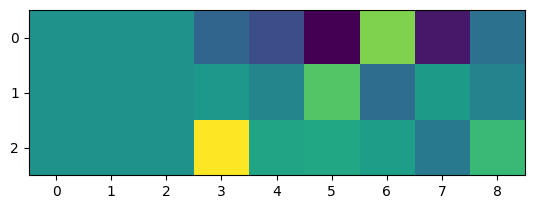

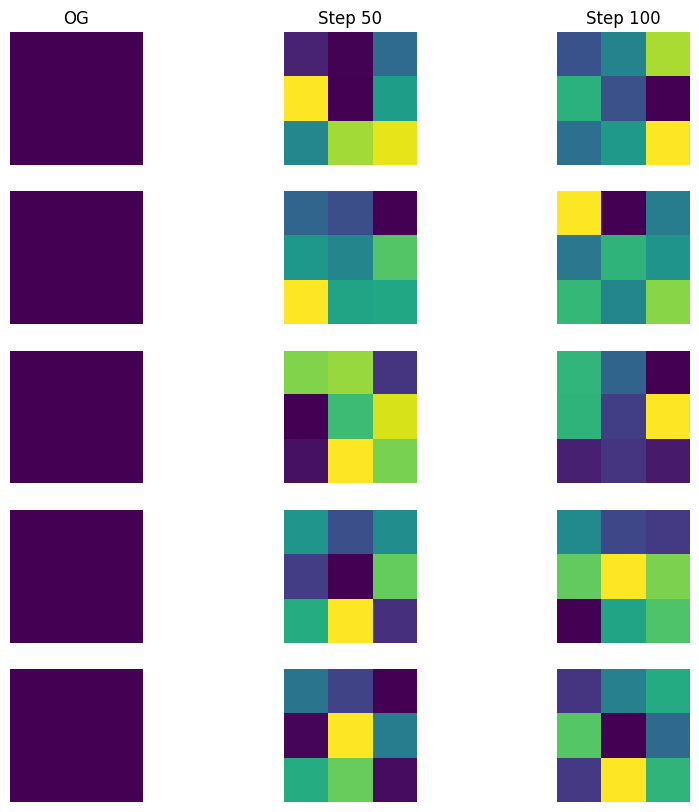

In [135]:
def get_noised_images(images, step, alphas_comulative_product):
    sqr_cp_alphas = np.sqrt(alphas_comulative_product[step])
    sqr_one_minus_cp_alphas = np.sqrt(1-alphas_comulative_product[step])
    eps  = torch.randn_like(images)
    noised_images = sqr_cp_alphas*images + sqr_one_minus_cp_alphas*eps
    return noised_images, eps

def plot_grid(images, labels):
    fig, axs = plt.subplots(images.shape[0], images.shape[1], figsize=(10,10))
    for i in range(images.shape[0]):
        for j in range(images.shape[1]):
            axs[i, j].imshow(images[i, :, (j*3):((j+1)*3)])
            try:
                axs[i, j].set_title(labels[i][j])
            except:
                pass
            axs[i, j].axis('off')
    
images, labels = next(iter(train_dataloader))
image = images[0:5]
noised_image_50, _ = get_noised_images(image, 50, alphas_cumprod)
noised_image_100, _ = get_noised_images(image, 100, alphas_cumprod)
# noised_image_300, _ = get_noised_images(image, 300, alphas_cumprod)
# noised_image_400, _ = get_noised_images(image, 400, alphas_cumprod)
# noised_image_499, _ = get_noised_images(image, 499, alphas_cumprod)

images_concat = torch.cat((image, noised_image_50, noised_image_100), dim=2)
import matplotlib.pyplot as hz

hz.imshow(images_concat[1])
labels = [['OG', 'Step 50', 'Step 100']]
plot_grid(images_concat, labels)


## Model Starts Here ##

In [142]:
import math
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

from torch import nn, einsum

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from tqdm.auto import tqdm


ModelPrediction =  namedtuple('ModelPrediction', ['pred_noise', 'pred_x_start'])

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def identity(t, *args, **kwargs):
    return t

def cycle(dl):
    while True:
        for data in dl:
            yield data

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def convert_image_to_fn(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image


def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5


def uniform(shape, device):
    return torch.zeros(shape, device = device).float().uniform_(0, 1)

def prob_mask_like(shape, prob, device):
    if prob == 1:
        return torch.ones(shape, device = device, dtype = torch.bool)
    elif prob == 0:
        return torch.zeros(shape, device = device, dtype = torch.bool)
    else:
        return torch.zeros(shape, device = device).float().uniform_(0, 1) < prob



class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Conv2d(dim, default(dim_out, dim), 4, 2, 1)

class WeightStandardizedConv2d(nn.Conv2d):
    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, 'o ... -> o 1 1 1', 'mean')
        var = reduce(weight, 'o ... -> o 1 1 1', partial(torch.var, unbiased = False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(x, normalized_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) * (var + eps).rsqrt() * self.g

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class RandomOrLearnedSinusoidalPosEmb(nn.Module):
    def __init__(self, dim, is_random = False):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim), requires_grad = not is_random)

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered



class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x



class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, classes_emb_dim = None, groups = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(int(time_emb_dim) + int(classes_emb_dim), dim_out * 2)
        ) if exists(time_emb_dim) or exists(classes_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None, class_emb = None):

        scale_shift = None
        if exists(self.mlp) and (exists(time_emb) or exists(class_emb)):
            cond_emb = tuple(filter(exists, (time_emb, class_emb)))
            cond_emb = torch.cat(cond_emb, dim = -1)
            cond_emb = self.mlp(cond_emb)
            cond_emb = rearrange(cond_emb, 'b c -> b c 1 1')
            scale_shift = cond_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)



class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        return self.to_out(out)



class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        attn = sim.softmax(dim = -1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)

        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)



class Unet(nn.Module):
    def __init__(
        self,
        dim,
        num_classes,
        cond_drop_prob = 0.5,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 3,
        resnet_block_groups = 8,
        learned_variance = False,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16,
    ):
        super().__init__()


        self.cond_drop_prob = cond_drop_prob


        self.channels = channels
        input_channels = channels

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        time_dim = dim * 4

        self.random_or_learned_sinusoidal_cond = learned_sinusoidal_cond or random_fourier_features

        if self.random_or_learned_sinusoidal_cond:
            sinu_pos_emb = RandomOrLearnedSinusoidalPosEmb(learned_sinusoidal_dim, random_fourier_features)
            fourier_dim = learned_sinusoidal_dim + 1
        else:
            sinu_pos_emb = SinusoidalPosEmb(dim)
            fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )


        self.classes_emb = nn.Embedding(num_classes, dim)
        self.null_classes_emb = nn.Parameter(torch.randn(dim))

        classes_dim = dim * 4

        self.classes_mlp = nn.Sequential(
            nn.Linear(dim, classes_dim),
            nn.GELU(),
            nn.Linear(classes_dim, classes_dim)
        )


        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim, classes_emb_dim = classes_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim, classes_emb_dim = classes_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim, classes_emb_dim = classes_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim, classes_emb_dim = classes_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim, classes_emb_dim = classes_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim, classes_emb_dim = classes_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim, classes_emb_dim = classes_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward_with_cond_scale(
        self,
        *args,
        cond_scale = 1.,
        **kwargs
    ):
        logits = self.forward(*args, **kwargs)

        if cond_scale == 1:
            return logits

        null_logits = self.forward(*args, cond_drop_prob = 1., **kwargs)
        return null_logits + (logits - null_logits) * cond_scale

    def forward(
        self,
        x,
        time,
        classes,
        cond_drop_prob = None
    ):
        batch, device = x.shape[0], x.device

        cond_drop_prob = default(cond_drop_prob, self.cond_drop_prob)

        classes_emb = self.classes_emb(classes)

        if cond_drop_prob > 0:
            keep_mask = prob_mask_like((batch,), 1 - cond_drop_prob, device = device)
            null_classes_emb = repeat(self.null_classes_emb, 'd -> b d', b = batch)

            classes_emb = torch.where(
                rearrange(keep_mask, 'b -> b 1'),
                classes_emb,
                null_classes_emb
            )

        c = self.classes_mlp(classes_emb)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t, c)
            h.append(x)

            x = block2(x, t, c)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t, c)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t, c)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t, c)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t, c)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)
        x = self.final_res_block(x, t, c)
        return self.final_conv(x)

In [146]:
class DiffuserModel(nn.Module):
    def __init__(self, model, steps, B_start, B_end, image_shape, channels):
        super(DiffuserModel, self).__init__()
        self.model = model
        self.steps = steps
        self.B_start = B_start
        self.B_end = B_end
        self.image_shape = image_shape
        self.channels = channels
        self.B = self.beta_scheduler()
        self.alphas = 1-self.B
        self.alphas_comulative_product = np.cumprod(self.alphas, axis = 0)

    def beta_scheduler(self, type = 'linear'): #defining the same function as above
        if type == 'linear':
            beta = np.linspace(self.B_start, self.B_end, self.steps)
        elif type == 'exponential':
            beta = np.exp(np.linspace(np.log(self.B_start), np.log(self.B_end), self.steps))
        return beta

    def get_noised_images(self, image, step):
        try:
          step = step.to('cpu')
        except:
          pass
        sqrt_alpha_cp = torch.Tensor(np.sqrt(self.alphas_comulative_product[step])).unsqueeze(dim=-1).unsqueeze(dim=-1).unsqueeze(dim=-1).to(device)
        sqrt_one_minus_alpha_cp = torch.Tensor(np.sqrt(1-self.alphas_comulative_product[step])).unsqueeze(dim=-1).unsqueeze(dim=-1).unsqueeze(dim=-1).to(device)
        eps = torch.randn_like(image).to(device)
        noised_image = sqrt_alpha_cp*image.to(device) + sqrt_one_minus_alpha_cp*eps
        return noised_image, eps

    def predict_noise_training(self, image, step, labels):
        noised_image, eps = self.get_noised_images(image, step)
        output = self.model(noised_image, step, labels)
        return output, eps

    def predict_noise(self, image_noised, step, labels):
        noise = self.model(image_noised, step, labels)
        return noise

    def generate_images(self, number_images, classes, all_steps = False):
        if not all_steps:
            model.eval()
            with torch.no_grad():
                gen = torch.randn(number_images, self.channels, self.image_shape, self.image_shape, device = device)
                for step in tqdm(range(self.steps)):

                    step = self.steps - step - 1
                    step = torch.full((number_images,), step)
                    pred_noise = self.predict_noise(gen, step.to(device), classes)
                    alpha = self.alphas[step]
                    alpha = torch.Tensor(alpha).to(device)[0]
                    cumul_alpha = torch.Tensor([self.alphas_comulative_product[step]]).to(device)[0][0]
                    gen = 1/alpha*(gen - ((1-alpha)/torch.sqrt(1 - cumul_alpha)) * pred_noise)
            model.train()
            return gen
        else:
            model.eval()
            with torch.no_grad():
                gen = torch.randn(number_images, self.channels, self.image_shape, self.image_shape, device = device)
                gen_steps = torch.randn(number_images, self.steps, self.image_shape, self.image_shape, device = device)
                for step in tqdm(range(self.steps)):

                    step = self.steps - step - 1
                    step = torch.full((number_images,), step)
                    #print(step)
                    pred_noise = self.predict_noise(gen, step.to(device), classes)
                    #print(pred_noise.shape)
                    alpha = self.alphas[step]
                    alpha = torch.Tensor(alpha).to(device)[0]
                    cumul_alpha = torch.Tensor([self.alphas_comulative_product[step]]).to(device)[0][0]
                    #print(cumul_alpha, alpha.shape, pred_noise.shape, gen.shape)
                    gen = 1/alpha*(gen - ((1-alpha)/torch.sqrt(1 - cumul_alpha)) * pred_noise)
                    gen_steps[:,step,:,:] = gen[:,0,:,:]
            model.train()
            return gen_steps


model = DiffuserModel(nn.DataParallel(Unet(
        dim = 16,
        channels = 1,
        dim_mults = (1, 2, 4, 8),
        num_classes = 10,
        cond_drop_prob = 0.5
    )).to(device), 100, 0.0001, 0.02, 32, 1)
images, _ = next(iter(train_dataloader))
images = images[0:4].to(device)
noised_images, eps = model.get_noised_images(images, [50,10,5,50])
print(noised_images.shape, eps.shape)
cat_images = torch.cat((images, noised_images), dim = 1).to('cpu')
plot_grid(cat_images,None)

classes_test = torch.ones(4, dtype = torch.int32, device = device)
gen = model.generate_images(4, classes_test)
print('geee', gen.shape)
plot_grid(torch.cat((gen,gen), dim = 1).to('cpu'), None)

gen_two = model.generate_images(4, classes_test, all_steps = True)
print(gen_two.shape)

results = {}

def train(parameters):
    if parameters['model']:
        model = parameters['model']
    else:
        model = DiffuserModel(nn.DataParallel(Unet(
        dim = 16,
        channels = 1,
        dim_mults = (1, 2, 4, 8),
        num_classes = 10,
        cond_drop_prob = 0.5
    )).to(device), parameters['steps'], parameters['B_start'], parameters['B_end'], parameters['image_shape'], parameters['channels'])
    optimizer = torch.optim.Adam(model.parameters(), lr = parameters['lr'][0])
    criterion = nn.MSELoss()
    for epoch in range(parameters['epochs']):
        if epoch%10 == 0 or epoch == parameters['epochs']-1:
          classes_test = torch.Tensor([0,1,2,3,4,5,6,7,8,9])
          classes_test = classes_test.to(dtype = torch.int32, device = device)
          gen = model.generate_images(10, classes_test)
          results['epc{}'.format(epoch)] = gen.to('cpu').detach().numpy()
          for i in range(gen.shape[0]):
              plt.imsave('image_{}_{}.png'.format(epoch, i), gen[i,0].to('cpu').detach().numpy(), cmap='gray')
            
        if epoch == 20:
            optimizer = torch.optim.Adam(model.parameters(), lr = parameters['lr'][1])
        losipoc = 0
        count = 0
        for i, data in tqdm(enumerate(train_dataloader)):
            images, labels = data
            images = images.to(device)
            ts = torch.randint(0, parameters['steps'], (images.shape[0],), device = device)
            output, eps = model.predict_noise_training(images, ts, labels.to(device))
            loss = criterion(output, eps)
            losipoc = losipoc + loss
            count = count + 1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(losipoc/count)


            
    return model

torch.Size([4, 4, 3, 3]) torch.Size([4, 3, 3])


RuntimeError: Tensors must have same number of dimensions: got 3 and 4